In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import pandas as pd
import pywt
import sklearn
import math

path = r'C:\Users\zzsgdsg7\Desktop\2021年B题\附件1 监测点A空气质量预报基础数据.xlsx'

data = pd.read_excel(path,sheet_name=1)
data.iloc[:,0] = pd.to_datetime(data.iloc[:,0])
data.set_axis(['time', 'place', 'so2','no2','pm10', 'pm2.5', 'o3','co','temperature', 'humidity', 'pressure','wind','direction'], axis='columns',inplace=True)
#print(data.head())

#数据基本处理
modeltime = data['time']
data = data.drop(columns=['place','time'])
data= data.replace('—', np.nan)
data = data.astype('float')
data[ data< 0 ] = np.nan
print(data.head())
data.insert(0,'time',modeltime)#重新插入时间列

#KNN插值

data_knn =data

def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):#判断值是否是空
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

for indexs in data.columns:
    if indexs =='time':
        continue
    data_knn[indexs] = knn_mean(data_knn[indexs].values,24)

   so2   no2  pm10  pm2.5    o3   co  temperature  humidity  pressure  wind  \
0  5.0  75.0  61.0   38.0   1.0  1.0         21.1      89.0    1013.0   1.2   
1  5.0  64.0  60.0   41.0  25.0  0.8         20.4      92.0    1012.4   1.1   
2  4.0  60.0  36.0   40.0  25.0  0.8         20.0      93.0    1011.3   1.1   
3  4.0  39.0  35.0   33.0  41.0  0.7         19.8      93.0    1010.4   1.5   
4  4.0  39.0  28.0   39.0  36.0  0.8         19.9      92.0    1010.0   1.5   

   direction  
0      346.5  
1       18.0  
2       65.9  
3       78.4  
4       73.5  


In [2]:
so2 = data_knn['so2']
no2 = data_knn['no2']
pm10 = data_knn['pm10']
pm25 = data_knn['pm2.5']
o3 = data_knn['o3']
co = data_knn['co']
temperature = data_knn['temperature']
humidity = data_knn['humidity']
pressure = data_knn['pressure']
wind = data_knn['wind']
direction = data_knn['direction']

maximum level is 4


<Figure size 432x288 with 0 Axes>

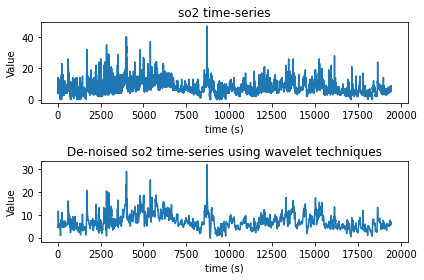

In [6]:

index = []
data = []
for i in range(len(so2)-1):
    X = float(i)
    Y = float(so2[i])
    index.append(X)
    data.append(Y)

# Create wavelet object and define parameters
w = pywt.Wavelet('sym8')  # 选用Daubechies8小波
maxlev = 4 #pywt.dwt_max_level(len(data), w.dec_len)
print("maximum level is " + str(maxlev))
threshold = 0.5  # Threshold for filtering

# Decompose into wavelet components, to the level selected:
coeffs = pywt.wavedec(data, 'sym8', level=maxlev)  # 将信号进行小波分解

plt.figure()
for i in range(1, len(coeffs)):
    coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))  # 将噪声滤波

datarec = pywt.waverec(coeffs, 'sym8')  # 将信号进行小波重构

mintime = 0
maxtime = mintime + len(data) + 1

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(index[mintime:maxtime], data[mintime:maxtime])
plt.xlabel('time (s)')
plt.ylabel('Value')
plt.title("so2 time-series")
plt.subplot(2, 1, 2)
plt.plot(index[mintime:maxtime], datarec[mintime:maxtime-1])
plt.xlabel('time (s)')
plt.ylabel('Value')
plt.title("De-noised so2 time-series using wavelet techniques")

plt.tight_layout()
plt.savefig( r'C:\Users\zzsgdsg7\Desktop\小波降噪结果.pdf')
plt.show()


In [ ]:
#评价指标


1222
5


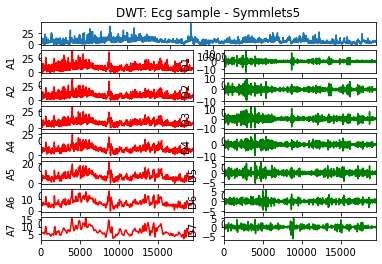

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data


ecg = pywt.data.ecg()

data1 = np.concatenate((np.arange(1, 400),
                        np.arange(398, 600),
                        np.arange(601, 1024)))
x = np.linspace(0.082, 2.128, num=1024)[::-1]
data2 = np.sin(40 * np.log(x)) * np.sign((np.log(x)))

mode = pywt.Modes.smooth


def plot_signal_decomp(data, w, title):
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet(w)#选取小波函数
    a = data
    ca = []#近似分量
    cd = []#细节分量
    for i in range(7):
        (a, d) = pywt.dwt(a, w, mode)#进行5阶离散小波变换
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))#重构

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        if i ==3:
            print(len(coeff))
            print(len(coeff_list))
        rec_d.append(pywt.waverec(coeff_list, w))

    fig = plt.figure()
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("A%d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("D%d" % (i + 1))


#plot_signal_decomp(data1, 'coif5', "DWT: Signal irregularity")
#plot_signal_decomp(data2, 'sym5',
#                   "DWT: Frequency and phase change - Symmlets5")
plot_signal_decomp(so2, 'sym5', "DWT: Ecg sample - Symmlets5")
plt.savefig( r'C:\Users\zzsgdsg7\Desktop\小波变换结果.pdf')

plt.show()